# Environment Setup

In [2]:
!git clone https://github.com/matteo4diani/ai-notebooks.git

Cloning into 'ai-notebooks'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 161 (delta 95), reused 97 (delta 39), pack-reused 0
Receiving objects: 100% (161/161), 392.62 KiB | 2.18 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [3]:
!mv /content/ai-notebooks/reddit-gender-classifier/custom_loaders.py /content/
!mv /content/ai-notebooks/reddit-gender-classifier/custom_preprocessing.py /content/
!mv /content/ai-notebooks/reddit-gender-classifier/custom_transformers.py /content/
!mv /content/ai-notebooks/reddit-gender-classifier/data /content/
!mv /content/ai-notebooks/reddit-gender-classifier/output /content/
!mv /content/ai-notebooks/reddit-gender-classifier/submissions /content/

In [11]:
!sudo apt-get update
!sudo apt-get install dos2unix
!dos2unix data/train_data.csv
!dos2unix data/test_data.csv
!dos2unix data/train_target.csv

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,965 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.

# Libraries

In [15]:
%matplotlib inline
from collections.abc import Iterable, Sequence
from collections import Counter
from collections import defaultdict
import copy
import enum
import time
from datetime import datetime
import calendar
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse
import re
import nltk
import xgboost

import custom_transformers 
import custom_preprocessing
import custom_loaders

from sklearn.experimental import enable_halving_search_cv

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, IsolationForest, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import FeatureUnion

from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline, Pipeline

import seaborn

# Load data

In [ ]:
#############
# Execution #
#############

training_features_dataframe, training_targets_dataframe = custom_loaders.get_dataframes_from_csv("data/train_data.csv",
                                                                                                 "data/train_target.csv")
training_comments : list[str] = list(training_features_dataframe.body)
training_targets : list[int] = custom_loaders.get_targets_from_dataframe(training_features_dataframe,
                                                                         training_targets_dataframe)

print(training_comments[:3])
print(training_targets[:3])

# Group by author

In [ ]:
#############
# Execution #
#############

training_features_dataframe_groupby_author = custom_loaders.group_dataframe_by_author(training_features_dataframe)

training_comments_groupby_author : list[str] = list(training_features_dataframe_groupby_author.body)
training_targets_groupby_author : list[int] = custom_loaders.get_targets_from_dataframe(training_features_dataframe_groupby_author,
                                                                                        training_targets_dataframe)

print(training_features_dataframe_groupby_author.head())
print(training_comments_groupby_author[:1])
print(training_targets_groupby_author[:5])

           author                                          subreddit  \
0          -Jared   AskReddit tall pics StarWars AskReddit AskReddit   
1         -Peeter                                             gainit   
2        -evasian  MouseReview MechanicalKeyboards jailbreak jail...   
3         -rubiks  AskWomen AskWomen AskWomen AskWomen AskWomen A...   
4  -true_neutral-                    mildlyinteresting todayilearned   

                                                body  \
0  Neil Diamond - Sweet Caroline +1 on the chirop...   
1                         Just read the FAQ, really.   
2  I just received my Deathadder Black Edition ye...   
3  AlunaGeorge - Best Be Believing\nArctic Monkey...   
4  &gt; Urban Ears Metis\n\nYMMV. I have had thre...   

                                         created_utc  
0  1390189315.0,1390189970.0,1390492589.0,1390496...  
1                                       1389962703.0  
2  1388678755.0,1388688144.0,1389891805.0,1389892...  
3  1389194

# Generate Part-Of-Speech data

We implement a custom vectorizer for Part-Of-Speech data.  
A survey of relevant literature points to personal pronouns, indefinite articles and other Parts-of-Speech as fairly accurate predictors of the author's gender.

In [ ]:
#############
# Execution #
#############

pos_vectorizer = custom_transformers.PosTagVectorizer()
print(pos_vectorizer.fit_transform(training_features_dataframe_groupby_author[1:10]))
print(pos_vectorizer.get_feature_names_out())

  (0, 2)	2.0
  (0, 11)	1.0
  (0, 28)	1.0
  (0, 32)	1.0
  (0, 36)	1.0
  (0, 40)	1.0
  (1, 1)	4.0
  (1, 2)	39.0
  (1, 3)	3.0
  (1, 4)	20.0
  (1, 5)	83.0
  (1, 6)	17.0
  (1, 7)	2.0
  (1, 11)	10.0
  (1, 12)	2.0
  (1, 13)	11.0
  (1, 14)	8.0
  (1, 15)	7.0
  (1, 17)	14.0
  (1, 18)	7.0
  (1, 19)	15.0
  (1, 22)	1.0
  (1, 23)	2.0
  (1, 24)	40.0
  (1, 25)	21.0
  :	:
  (8, 22)	28.0
  (8, 24)	85.0
  (8, 25)	181.0
  (8, 26)	1.0
  (8, 27)	47.0
  (8, 28)	115.0
  (8, 29)	188.0
  (8, 30)	44.0
  (8, 31)	16.0
  (8, 32)	166.0
  (8, 33)	7.0
  (8, 34)	7.0
  (8, 35)	4.0
  (8, 36)	207.0
  (8, 37)	347.0
  (8, 38)	7.0
  (8, 39)	1.0
  (8, 40)	55.0
  (8, 41)	58.0
  (8, 42)	1.0
  (8, 43)	69.0
  (8, 44)	9.0
  (8, 45)	5.0
  (8, 46)	18.0
  (8, 47)	115.0
['74' '99' '164681854541413346' '272890857012483650' '783433942507015291'
 '1292078113972184607' '1534113631682161808' '1895579588947004264'
 '1982173196287093141' '2294095510757837556' '2465883113906300949'
 '2593208677638477497' '3252815442139690129' '382238504955637

# Generate subreddit data

In [ ]:
#############
# Execution #
#############

subreddit_vectorizer = custom_transformers.SubredditVectorizer()
print(subreddit_vectorizer.fit_transform(training_features_dataframe_groupby_author))
print(subreddit_vectorizer.get_feature_names_out())

  (0, 139)	3.0
  (0, 1313)	1.0
  (0, 2844)	1.0
  (0, 3220)	1.0
  (1, 2243)	1.0
  (2, 139)	1.0
  (2, 916)	1.0
  (2, 958)	1.0
  (2, 2446)	7.0
  (3, 132)	1.0
  (3, 148)	8.0
  (4, 2631)	1.0
  (4, 3274)	1.0
  (5, 2407)	3.0
  (5, 3270)	1.0
  (6, 2683)	1.0
  (7, 139)	1.0
  (8, 728)	1.0
  (8, 1745)	2.0
  (8, 3304)	2.0
  (9, 52)	1.0
  (9, 139)	12.0
  (9, 193)	1.0
  (9, 728)	2.0
  (9, 1521)	5.0
  :	:
  (4992, 1468)	3.0
  (4992, 1473)	5.0
  (4992, 2724)	5.0
  (4992, 3161)	6.0
  (4992, 3292)	1.0
  (4992, 3342)	4.0
  (4993, 1193)	2.0
  (4993, 1867)	1.0
  (4994, 2506)	3.0
  (4995, 1054)	1.0
  (4996, 52)	4.0
  (4996, 345)	1.0
  (4996, 904)	4.0
  (4996, 1004)	20.0
  (4996, 1420)	1.0
  (4996, 1697)	1.0
  (4996, 2171)	2.0
  (4996, 2204)	2.0
  (4996, 2284)	1.0
  (4996, 2567)	1.0
  (4996, 2844)	1.0
  (4997, 3368)	4.0
  (4998, 1114)	3.0
  (4998, 2801)	1.0
  (4999, 139)	2.0
['1022' '1200isplenty' '1911' ... 'zen' 'zombies' 'zyzz']


# Generate timestamp data

We create a custom timestamp vectorizer that turns the list of epoch times in the `created_utc` feature (grouped by author) in a matrix of counts binned by weekday and hour.  
By plotting user activity we notice significant outliers: the honorable mention goes to the user ___u/morbiusgreen___, still active on various subs and posting up to 500 comments in one hour.  
We will later implement an outlier removal routine to get rid of the graphomaniacs (and other outliers) tainting our dataset.

In [ ]:
#############
# Execution #
#############

epoch_vectorizer = custom_transformers.EpochVectorizer()
print(epoch_vectorizer.fit_transform(training_features_dataframe_groupby_author))
print(epoch_vectorizer.get_feature_names_out())

  (0, 3)	2.0
  (0, 87)	1.0
  (0, 89)	1.0
  (0, 92)	1.0
  (0, 93)	1.0
  (1, 108)	1.0
  (2, 39)	1.0
  (2, 61)	1.0
  (2, 63)	2.0
  (2, 66)	1.0
  (2, 88)	1.0
  (2, 89)	2.0
  (2, 90)	1.0
  (2, 93)	1.0
  (3, 63)	1.0
  (3, 86)	3.0
  (3, 98)	2.0
  (3, 109)	1.0
  (3, 111)	1.0
  (3, 148)	1.0
  (4, 72)	1.0
  (4, 100)	1.0
  (5, 4)	1.0
  (5, 22)	2.0
  (5, 26)	1.0
  :	:
  (4996, 66)	1.0
  (4996, 67)	2.0
  (4996, 68)	1.0
  (4996, 70)	4.0
  (4996, 88)	3.0
  (4996, 89)	3.0
  (4996, 90)	1.0
  (4996, 91)	1.0
  (4996, 98)	3.0
  (4996, 103)	1.0
  (4996, 105)	1.0
  (4996, 111)	2.0
  (4996, 114)	1.0
  (4996, 117)	4.0
  (4996, 119)	1.0
  (4996, 121)	1.0
  (4996, 136)	1.0
  (4996, 164)	1.0
  (4997, 20)	2.0
  (4997, 23)	2.0
  (4998, 26)	1.0
  (4998, 27)	1.0
  (4998, 28)	1.0
  (4998, 119)	1.0
  (4999, 82)	2.0
['000_MONDAY_00' '001_MONDAY_01' '002_MONDAY_02' '003_MONDAY_03'
 '004_MONDAY_04' '005_MONDAY_05' '006_MONDAY_06' '007_MONDAY_07'
 '008_MONDAY_08' '009_MONDAY_09' '010_MONDAY_10' '011_MONDAY_11'
 '012_MONDA

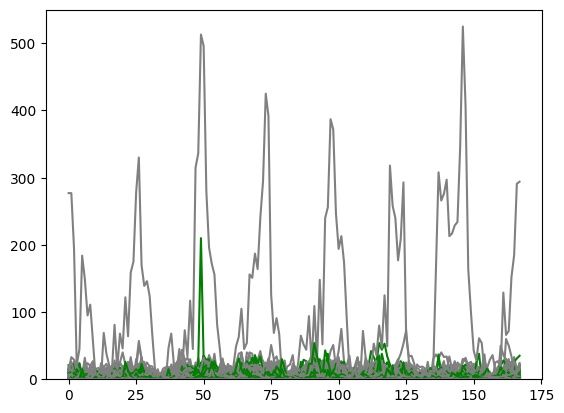

In [ ]:
#########
# Plots #
#########
colormap = np.array(['gray', 'g'])
colors = colormap[training_targets_groupby_author]

lines = plt.plot(np.array(range(168)).T,epoch_vectorizer.transform(training_features_dataframe_groupby_author).toarray().T)
ax = plt.gca()
ax.set_ylim([0, 550])

for idx, color in enumerate(colors):
    lines[idx].set_color(color)
plt.show()

# Generate username data

We create a custom username vectorizer, counting single-character occurrence and total length of the username.

In [ ]:
#############
# Execution #
#############

username_vectorizer = custom_transformers.UsernameVectorizer()
print(username_vectorizer.fit_transform(training_features_dataframe_groupby_author).A)
print(username_vectorizer.get_feature_names_out())


[[1 0 0 ... 0 0 6]
 [1 0 0 ... 0 0 7]
 [1 0 0 ... 0 0 8]
 ...
 [0 0 0 ... 0 2 7]
 [0 0 0 ... 0 2 4]
 [0 0 0 ... 0 2 7]]
['-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'length']


# Generate TF-IDF comment data

We wrap the built-in `TfIdfVectorizer` in a `BodyVectorizer` class (see `custom_transformers`). We enrich the built-in vectorizer with lemmatization via `nltk.stem.WordNetLemmatizer`.

# Data Clean-up

## Outlier Rejection

We reject outliers based on anomalous comments/hour. We leverage the `sklearn.ensemble.IsolationForest` classifier, which is a tree-based anomaly detection algorithm.  
Even if it's feasible to manipulate both features and targets in-pipeline via `imblearn.pipeline.Pipeline` after some experiments we decide integrating outlier detection in the pipeline is not necessary.

## Textual Data Cleaning

We process letters-only words of three or more characters by lemmatizing them via `nltk.stem.WordNetLemmatizer` embedded in a custom tokenizer passed to `TfidfVectorizer` (see `custom_transformers.tokenize`). We don't use the built-in english stop-words as they contain some Parts-Of-Speech that can be useful for author characterization.

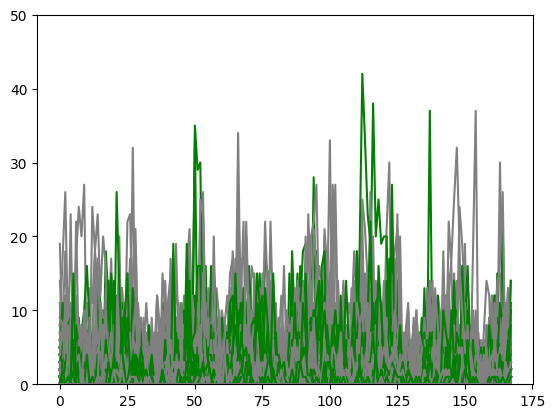

# of valid samples: 4751


In [ ]:
#########
# Plots #
#########
epoch_vectorizer = custom_transformers.EpochVectorizer()

X_outliers = epoch_vectorizer.fit_transform(training_features_dataframe_groupby_author)
y_outliers = training_targets_groupby_author

reject_sampler = FunctionSampler(func=custom_preprocessing.outlier_rejection)
X_inliers, y_inliers = reject_sampler.fit_resample(X_outliers, y_outliers)

colormap = np.array(['gray', 'g'])
colors = colormap[y_inliers]

lines = plt.plot(np.array(range(168)).T,X_inliers.toarray().T)
ax = plt.gca()
ax.set_ylim([0, 50])

for idx, color in enumerate(colors):
    lines[idx].set_color(color)
plt.show()
print(f'# of valid samples: {len(y_inliers)}')

# Latent Semantic Analysis

We implement LSA in our pipeline using the built-ins `TruncatedSVD` and `LatentDirichletAllocation`.

# Training Pipeline

We compose a pipeline that combines all our vectorizers via `FeatureUnion`, scales the data via `MaxAbsScaler`, performs latent semantic analysis via `TruncatedSVD`, and fits it via different estimators `LogisticRegression` and `SVC`

In [20]:
#####################
# Training Pipeline #
#####################
def get_training_pipeline():
    features = FeatureUnion([("vct", custom_transformers.BodyVectorizer(ngram_range=(1,1), max_features=1000)),
                             ("usr", custom_transformers.UsernameVectorizer(ngram_range=(1,1))),
                             ("sub", custom_transformers.SubredditVectorizer())])
    
    features_dict = dict([("vct", custom_transformers.BodyVectorizer(ngram_range=(1,1), max_features=1000)),
                          ("pos", custom_transformers.PosTagVectorizer()),
                          ("utc", custom_transformers.EpochVectorizer()),
                          ("usr", custom_transformers.UsernameVectorizer(ngram_range=(1,1))),
                          ("sub", custom_transformers.SubredditVectorizer())])
                                  


    training_pipeline = Pipeline([("features", features),
                                  ("outliers", FunctionSampler(func=custom_preprocessing.outlier_rejection)),
                                  ("scaler", MaxAbsScaler()),
                                  ("lsa", TruncatedSVD(n_components=100, random_state=0)),
                                  ("classifier", SVC(random_state=0))],
                                 verbose=True)
    return training_pipeline

In [21]:
#############
# Model Fit #
#############

final_features, final_targets = custom_loaders.get_training_data()
training_pipeline = get_training_pipeline()
# training_pipeline.fit(final_features[1:100], final_targets[1:100])
# print(training_pipeline.score(final_features, final_targets))
# print(cross_val_score(training_pipeline, final_features, final_targets, n_jobs=-1, verbose=100, scoring='roc_auc'))

# Model Selection

We do a `GridSearchCV` with a `StratifiedShuffleSplit` for each feature group on itself (usernames, subreddits, etc.) and all together.  
Comment times are useful to identify outliers but don't perform well as gender predictors (at least with our pipeline, maybe with a rolling average/different classifier they would perform better). PoS tags are very expensive for not much benefit.  
While visualizing features we notice we have mixed languages in our bunch, and they get represented as segregated topics. 

In [82]:
###################
# Model Selection #
###################
from sklearn.feature_selection import chi2, SelectFpr
from sklearn.metrics import roc_auc_score
# SVD/SelectKBest/LDA parameters
n_components = [100, 200, 400]
ks = [100, 200, 400]

# Tf-Idf parameters
max_dfs = [1.0, 0.7]
min_dfs = [1, 0.3]
token_patterns = [r"(?u)\b\w\w+\b"] # without lemmatization
tokenizers = [custom_transformers.tokenize] # with lemmatization
ngrams_tfidf = [(1, 1), (1, 2)]

# Username CountVectorizer parameters
ngrams_username = [(1, 1), (3, 3)]

# SVC parameters
gammas = ['scale']
cs = [0.01, 0.1, 1, 10]

# Classifiers 
classifiers = [LogisticRegression(C=1, max_iter=10000, random_state=0), 
               SVC(C=1, gamma='scale', random_state=0, probability=True, verbose=True),
               RandomForestClassifier(criterion='entropy', 
                                      max_depth=None,
                                      n_estimators=300,
                                      bootstrap=False,
                                      random_state=0)]

# Dimensionality reduction
reducers = [LatentDirichletAllocation(random_state=0), 
            TruncatedSVD(random_state=0), 
            SelectKBest(k=100),
            SelectFpr(alpha=0.01)]

# Scaling

scalers = [MaxAbsScaler(), MinMaxScaler(feature_range=(-1, 1))]

svc_param_grid = [{'features__vct__max_features' : [20000],
                   'features__vct__tokenizer' : tokenizers,
                   'features__vct__ngram_range' : [(1, 3)],
                   'features__usr__ngram_range' : [(1, 3)],
                   'scaler' : [scalers[0]],
                   'lsa' : [reducers[3]],
                   'lsa__alpha' : np.linspace(0.015, 0.030, 3), #np.logspace(-3, -1, 5),
                   #'lsa__n_components' : [500], 
                   'classifier__C' : [1], #np.logspace(-2,2, num=20), 
                   'classifier__gamma' : ['scale'], #*np.logspace(-2,2, num=20),
                   'classifier' : [classifiers[1]]}]

lr_param_grid = [{'features__vct__max_features' : [20000],
                   'features__vct__tokenizer' : tokenizers,
                   'features__vct__ngram_range' : [(1, 3)],
                   'features__usr__ngram_range' : [(1, 3)],
                   'lsa__n_components' : [500], 
                   'classifier__C' : [1], 
                   'classifier' : [classifiers[0]]}]

rf_param_grid = [{'features__vct__max_features' : [20000],
                   'features__vct__tokenizer' : tokenizers,
                   'features__vct__ngram_range' : [(1, 3)],
                   'features__usr__ngram_range' : [(1, 3)],
                   'scaler' : [None],
                   'lsa__n_components' : [500], 
                   'classifier' : [classifiers[2]]}]


voting_param_grid = [{
    'features__vct__max_features' : [20000],
    'features__vct__tokenizer' : tokenizers,
    'features__vct__ngram_range' : [(1, 3)],
    'features__usr__ngram_range' : [(1, 3)],
    'lsa__n_components' : [500], 
    'classifier' : [VotingClassifier([('lr', classifiers[0]),
                                      ('svc', classifiers[1]),
                                      ('rf', classifiers[2])], 
                                     voting='soft')]}]

selection_pipeline = GridSearchCV(training_pipeline, 
                                  param_grid=svc_param_grid, 
                                  scoring='roc_auc', 
                                  n_jobs=-1,
                                  verbose=100,
                                  cv=StratifiedShuffleSplit(n_splits=5, train_size=0.80, random_state=0))

selection_pipeline.fit(final_features, final_targets)
custom_loaders.save_dict_to_disk(selection_pipeline.cv_results_)
print(selection_pipeline.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Pipeline] .......... (step 1 of 5) Processing features, total=   8.5s
[Pipeline] .......... (step 2 of 5) Processing outliers, total=   2.5s
[Pipeline] ............ (step 3 of 5) Processing scaler, total=   0.1s
[Pipeline] ............... (step 4 of 5) Processing lsa, total=   0.0s
[LibSVM][Pipeline] ........ (step 5 of 5) Processing classifier, total=  41.8s
{'classifier': SVC(C=1, probability=True, random_state=0, verbose=True), 'classifier__C': 1, 'classifier__gamma': 'scale', 'features__usr__ngram_range': (1, 3), 'features__vct__max_features': 20000, 'features__vct__ngram_range': (1, 3), 'features__vct__tokenizer': <function tokenize at 0x7fe7a90ee950>, 'lsa': SelectFpr(alpha=0.015), 'lsa__alpha': 0.015, 'scaler': MaxAbsScaler()}


In [81]:
np.linspace(0.015, 0.005, 5)[0]

0.015

In [83]:
pd.DataFrame.from_dict(selection_pipeline.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__gamma,param_features__usr__ngram_range,param_features__vct__max_features,param_features__vct__ngram_range,...,param_scaler,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,49.438432,1.864088,3.126822,0.124837,"SVC(C=1, probability=True, random_state=0, ver...",1,scale,"(1, 3)",20000,"(1, 3)",...,MaxAbsScaler(),"{'classifier': SVC(C=1, probability=True, rand...",0.840996,0.847518,0.832392,0.842474,0.838602,0.840397,0.004953,1
1,52.374254,1.714556,3.225025,0.151244,"SVC(C=1, probability=True, random_state=0, ver...",1,scale,"(1, 3)",20000,"(1, 3)",...,MaxAbsScaler(),"{'classifier': SVC(C=1, probability=True, rand...",0.841119,0.849429,0.826439,0.840081,0.835573,0.838528,0.007521,3
2,50.515326,3.750735,2.786675,0.497704,"SVC(C=1, probability=True, random_state=0, ver...",1,scale,"(1, 3)",20000,"(1, 3)",...,MaxAbsScaler(),"{'classifier': SVC(C=1, probability=True, rand...",0.843696,0.849452,0.831460,0.839863,0.832922,0.839479,0.006703,2


In [ ]:
selection_pipeline.score(final_features, final_targets)

0.9689581269126082

# Feature Visualization

In [ ]:
#########################
# Feature Visualization #
#########################

pipeline_to_visualize = selection_pipeline.best_estimator_
feature_names = [*pipeline_to_visualize.steps[0][1].transformer_list[0][1].vectorizer.get_feature_names_out(),
                 *pipeline_to_visualize.steps[0][1].transformer_list[1][1].vectorizer.get_feature_names_out(),
                 'USERNAME_LENGTH',
                 *pipeline_to_visualize.steps[0][1].transformer_list[2][1].vectorizer.get_feature_names_out()]

for idx, feature in enumerate(list(pipeline_to_visualize.steps[2][1].components_)):
    row = f'Component {idx:03}: '
    for idf, component in enumerate(feature):
        if (idf < len(feature_names) and component > 0.035):
            row = row + f'{feature_names[idf]} '  
    print(row)

# Evaluate on Test Set

In [ ]:
test_features = custom_loaders.get_test_data()
predictions = selection_pipeline.predict_proba(test_features)

In [ ]:
custom_loaders.save_submission_to_disk(test_features, predictions[:,1])